In [2]:
!pip install torch-scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp39-cp39-linux_x86_64.whl size=3246013 sha256=254dd34bca138425cc1071f7f0855d77dbfb5223792b6156361ba398de68d62e
  Stored in directory: /root/.cache/pip/wheels/ce/93/4d/e0ac930bf835875dc2ee0e72a181de0b7fca3c4c6f2fe9188f
Successfully built torch-scatter


In [1]:
import os
import urllib
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
import scipy.sparse as sp
from zipfile import ZipFile
import pickle
import pandas as pd
import torch_scatter
from collections import Counter

from src.GAT import *
from data.DD.DD import DDDataset


ModuleNotFoundError: No module named 'torch_scatter'

D&D is a dataset of 1178 protein structures (Dobson and Doig, 2003). Each protein is represented by a graph, in which the nodes are amino acids and two nodes are connected by an edge if they are less than 6 Angstroms apart. The prediction task is to classify the protein structures into enzymes and non-enzymes.



In [3]:
dataset = DDDataset()

/notebooks/GNN/data
Loading DD_A.txt
Loading DD_node_labels.txt
Loading DD_graph_indicator.txt
Loading DD_graph_labels.txt
Number of nodes:  334925


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
adjacency = dataset.sparse_adjacency
normalize_adjacency = normalization(adjacency).to(DEVICE)
node_labels = tensor_from_numpy(dataset.node_labels, DEVICE)
node_features = F.one_hot(node_labels, node_labels.max().item() + 1).float()
graph_indicator = tensor_from_numpy(dataset.graph_indicator, DEVICE)
graph_labels = tensor_from_numpy(dataset.graph_labels, DEVICE)
train_index = tensor_from_numpy(dataset.train_index, DEVICE)
test_index = tensor_from_numpy(dataset.test_index, DEVICE)
train_label = tensor_from_numpy(dataset.train_label, DEVICE)
test_label = tensor_from_numpy(dataset.test_label, DEVICE)


In [5]:
INPUT_DIM = node_features.size(1)
NUM_CLASSES = 2
EPOCHS = 200
HIDDEN_DIM = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4

In [6]:
model_g = ModelA(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
model_h = ModelB(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)

In [7]:
model = model_g

In [8]:
print("Device:", DEVICE)
print(model)

Device: cuda
ModelA(
  (gcn1): GraphConvolution (89 -> 32)
  (gcn2): GraphConvolution (32 -> 32)
  (gcn3): GraphConvolution (32 -> 32)
  (pool): SelfAttentionPooling(
    (attn_gcn): GraphConvolution (96 -> 1)
  )
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model.train()
accuracy = []
for epoch in range(EPOCHS):
    logits = model(normalize_adjacency, node_features, graph_indicator)
    loss = criterion(logits[train_index], train_label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_acc = torch.eq(logits[train_index].max(1)[1], train_label).float().mean()
    accuracy.append(train_acc.cpu().numpy())
    if epoch%10 == 0:
        print("Epoch {:03d}: Loss {:.4f}, TrainAcc {:.4}".format(
            epoch, loss.item(), train_acc.item()))


Epoch 000: Loss 0.4257, TrainAcc 0.8355
Epoch 010: Loss 0.4362, TrainAcc 0.8259
Epoch 020: Loss 0.4401, TrainAcc 0.8217
Epoch 030: Loss 0.4347, TrainAcc 0.8312
Epoch 040: Loss 0.4261, TrainAcc 0.8344
Epoch 050: Loss 0.4230, TrainAcc 0.8386
Epoch 060: Loss 0.4188, TrainAcc 0.8408
Epoch 070: Loss 0.4158, TrainAcc 0.8408
Epoch 080: Loss 0.4125, TrainAcc 0.8418
Epoch 090: Loss 0.4088, TrainAcc 0.845
Epoch 100: Loss 0.4049, TrainAcc 0.845
Epoch 110: Loss 0.4006, TrainAcc 0.8471
Epoch 120: Loss 0.3959, TrainAcc 0.8482
Epoch 130: Loss 0.3904, TrainAcc 0.8493
Epoch 140: Loss 0.3842, TrainAcc 0.8493
Epoch 150: Loss 0.3775, TrainAcc 0.8514
Epoch 160: Loss 0.3686, TrainAcc 0.8524
Epoch 170: Loss 0.3575, TrainAcc 0.8546
Epoch 180: Loss 0.3468, TrainAcc 0.8567
Epoch 190: Loss 0.3372, TrainAcc 0.8567


In [11]:
model.eval()
with torch.no_grad():
    logits = model(normalize_adjacency, node_features, graph_indicator)
    test_logits = logits[test_index]
    test_acc = torch.eq(test_logits.max(1)[1], test_label).float().mean()
print(test_acc.item())

0.7288135886192322


Text(0.5, 1.0, '0.8609342')

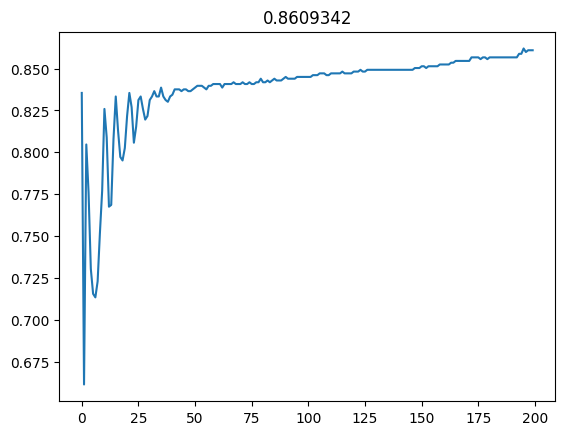

In [22]:
plt.plot(acc)
plt.title(acc[-1])